# World Rugby ranking simulator

In this notebook, we read a current World Rugby rankings and a list of fixtures.
We then iterate over the list of fixtures, simulate their results, and update the rankings accordingly.
We repeat that process several times, and explore the distribution of rankings.

The code for the exploration could clearly be optimised, but this is not the point here.

## Data loading

We start by reading the current rankings.

In [1]:
from ast import literal_eval

initial_rankings = dict()

with open("rankings_mens.tsv",'r') as inFile:
    for line in inFile:
        team, points = line.rstrip().split("\t")
        
        if team in initial_rankings:
            print(f"Error: {team} has already been added.")
            
        initial_rankings[team] = round(literal_eval(points),2)

Next, we load the list of fixtures:

In [2]:
fixtures = []

with open("fixture_list.tsv",'r') as inFile:
    for line in inFile:
        
        # we ignore comments
        if line[0]=="#":
            continue
        
        # we extract one fixture
        temp_array = line.rstrip().split("\t")
        
        # we perform some basic quality control
        if len(temp_array) not in [6,9]:
            print(f"We expect the line to contain 6 or 8 elements, but it contains {len(temp_array)}:\n{line}")
        if temp_array[0] not in initial_rankings:
            print(f"{temp_array[0]} is not in the initial rankings")
        if temp_array[1] not in initial_rankings:
            print(f"{temp_array[0]} is not in the initial rankings")
            
        # we transform scores and probabilities into numerical values
        for i in range(4,len(temp_array)):
            temp_array[i] = literal_eval(temp_array[i])
            
        # we perform some additional quality control
        if len(temp_array)==9:
            total = round(sum(temp_array[4:]),5) # we are rounding here, to avoid issues with floating point numbers
            if total!=1:
                print(f"The probabilities need to add up to 1, rather than {total}: {temp_array}")
        elif len(temp_array)==6:
            if temp_array[4]<0 or temp_array[5]<0:
                print(f"Scores can only be non-negative values: {temp_array}")

            
        fixtures.append(temp_array)

print(f"We will simulate the results of {len(fixtures)} games.")

We will simulate the results of 42 games.


## Support functions

Next, we prepare functions that will handle specific parts of the simulations.

We need a function that will calculate the outcome of a game based on probabilities given in the fixture list and return the outcome category:
1. Team A wins by strictly more than 15 points
2. Team A wins by up to 15 points
3. Draw
4. Team B wins by up to 15 points
5. Team B wins by strictly more than 15 points

In [3]:
import random
random.seed(2025)

def simulate_one_match(array):
    
    # an array of length 6 contains a result, rather than a prediction
    if len(array)==6:
        # we extract the point difference
        pointsA = array[4]
        pointsB = array[5]
        difference = pointsA-pointsB
        
        # we return the outcome
        if difference>15:
            return 1
        elif difference>0:
            return 2
        elif difference==0:
            return 3
        elif difference>-15:
            return 4
        else:
            return 5
        
    # an array of length 9 (no other length is possible) contains a prediction
    else:
        # we extract the probabilities
        p_A15 = array[4]
        p_A = array[5]
        p_draw = array[6]
        p_B = array[7]
        p_B15 = array[8]
        
        # we generate a random number between 0 and 1
        random_number = random.random()
        
        # we determine the outcome
        if random_number < p_A15:
            return 1
        elif random_number < p_A15+p_A:
            return 2
        elif random_number < p_A15+p_A+p_draw:
            return 3
        elif random_number < p_A15+p_A+p_draw+p_B:
            return 4
        elif random_number < p_A15+p_A+p_draw+p_B+p_B15:
            return 5
        else:
            print(f"Error in processing game: {array}")
            return None


We also need a function that calculates the point changes based on current rankings and game outcome.

In [4]:
def calculate_point_changes(pointsA, pointsB, atHome, isRWC, game_outcome):
    
    # if a team has home advantage, 3 points are added to its pre-match ranking
    # given how we capture the fixture list, only team A may have home advantage
    adjustedA = pointsA
    if atHome:
        adjustedA+=3
        
    point_exchange = 0
    
    if outcome == 1:
        point_exchange = round(min(3,abs(10+pointsB-adjustedA)*0.15),2)
        
        if adjustedA-pointsB>=10: # if team A won, but was more than 10 ranking points ahead, no point exchange
            point_exchange=0

    elif outcome == 2:
        point_exchange = round(min(2,abs(10+pointsB-adjustedA)*0.1),2)
        
        if adjustedA-pointsB>=10: # if team A won, but was more than 10 ranking points ahead, no point exchange
            point_exchange=0

    elif outcome == 3:
        point_exchange = round(min(1,abs(pointsB-adjustedA)*0.1),2)
    elif outcome == 4:
        point_exchange = round(min(2,abs(10+adjustedA-pointsB)*0.1),2)
        
        if pointsB-adjustedA>=10: # if team B won, but was more than 10 ranking points ahead, no point exchange
            point_exchange=0

    elif outcome == 5:
        point_exchange = round(min(3,abs(10+adjustedA-pointsB)*0.15),2)
        
        if pointsB-adjustedA>=10: # if team B won, but was more than 10 ranking points ahead, no point exchange
            point_exchange=0

        
    # if it is a RWC game, we double the points
    if isRWC:
        point_exchange = 2*point_exchange
        
    return point_exchange
    

## Processing the list of fixtures

We are going to simulate the games in our fixture list. After each game, we update the rankings. Once we have processed all the games, we get the ranking points as the end date.

We separately this process several times. The number of trials is controls by `n_sim`.

In [5]:
from copy import deepcopy
from tqdm import tqdm

n_sim = 100000

# we create an array where each entry will be one dictionary of ranking points
sim_rank = []

for sim in tqdm(range(0,n_sim)):
    
    # we initialise simulated_rankings[sim] to contain the initial rankings
    sim_rank.append(deepcopy(initial_rankings))
    
    # for each game in the fixture list
    for game in fixtures:
        
        # we simulate an outcome
        outcome = simulate_one_match(game)
        
        teamA = game[0]
        teamB = game[1]
        home_advantage = (game[2]=='home')
        RWC_game = (game[3]=='RWC')
        
        pointsA = sim_rank[sim][teamA]
        pointsB = sim_rank[sim][teamB]
        
        # we calculate the point exchange
        exchange = calculate_point_changes(pointsA, pointsB, home_advantage, RWC_game, outcome)
        
        # we update the ranking points
        if outcome<=2:
            # if team A won, they gain points and team B loses points
            sim_rank[sim][teamA]+=exchange
            sim_rank[sim][teamB]-=exchange
        elif outcome>=4:
            # if team B won, they gain points and team A loses points
            sim_rank[sim][teamB]+=exchange
            sim_rank[sim][teamA]-=exchange
        else:
            # if it is a draw, and team A had more points, they lose points
            if sim_rank[sim][teamA]>sim_rank[sim][teamB]:
                sim_rank[sim][teamA]-=exchange
                sim_rank[sim][teamB]+=exchange
            # and if team A had fewer points, they win points
            else:
                sim_rank[sim][teamA]+=exchange
                sim_rank[sim][teamB]-=exchange      

        # we round scores back to two significant digits
        sim_rank[sim][teamA] = round(sim_rank[sim][teamA],2)
        sim_rank[sim][teamB] = round(sim_rank[sim][teamB],2)


100%|██████████| 100000/100000 [00:34<00:00, 2871.74it/s]


## Exploring the results

Now, we can explore the results.

### Ranking points distributions

We create a violin plot to show the distribution of final ranking points for some teams of interest.

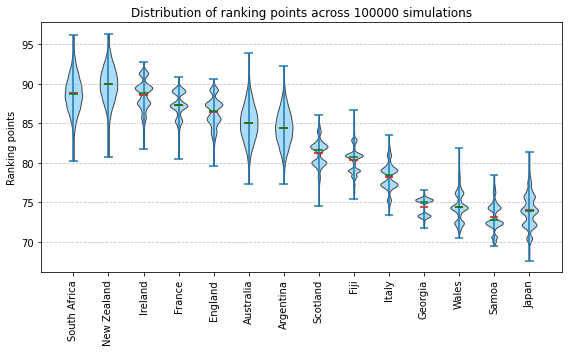

In [6]:
import matplotlib.pyplot as plt

teams_to_plot = ["South Africa", "New Zealand", "Ireland", "France", "England", "Australia", "Argentina", 
                 "Scotland", "Fiji", "Italy", "Georgia", "Wales", "Samoa", "Japan"]

# Collect points for each team
team_points = {team: [] for team in teams_to_plot}

for sim in sim_rank:
    for team in teams_to_plot:
        if team in sim:
            team_points[team].append(sim[team])

# Prepare data for plotting
data = [team_points[team] for team in teams_to_plot]

# Create violin plot
plt.figure(figsize=(8, 5),facecolor='white')
parts = plt.violinplot(data, showmeans=True, showextrema=True, showmedians=True)

# Custom colors for violins
for pc in parts['bodies']:
    pc.set_facecolor('#87CEFA')  # light blue
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Different colors for mean and median lines
parts['cmeans'].set_color('red')      # mean line in red
parts['cmedians'].set_color('green')  # median line in green

# Labels
plt.xticks(
    range(1, len(teams_to_plot) + 1),
    teams_to_plot,
    rotation=90
)
plt.ylabel('Ranking points')
plt.title(f"Distribution of ranking points across {n_sim} simulations")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig("point_distributions.png")
plt.show()


### Most common ranking

Next, we look at which position each team is most commonly ranked.

In [7]:
teams_to_analyse = ["South Africa", "New Zealand", "Ireland", "France", "England", "Australia",
                    "Argentina", "Scotland", "Fiji", "Italy", "Georgia", "Wales", "Samoa",
                    "Japan", "Spain", "USA", "Uruguay", "Portugal", "Tonga", "Chile"]

from collections import Counter

# Store rankings for each team
rankings = {team: [] for team in teams_to_analyse}

for sim in sim_rank:
    # Sort teams by points (highest first)
    sorted_teams = sorted(sim.items(), key=lambda x: x[1], reverse=True)
    # Create a mapping: team → rank (1-based)
    team_to_rank = {team: rank+1 for rank, (team, _) in enumerate(sorted_teams)}

    # Record the rank for each team in teams_to_analyse
    for team in teams_to_analyse:
        if team in team_to_rank:
            rankings[team].append(team_to_rank[team])

# Find most frequent rank for each team
most_frequent_ranks = {}
for team, rank_list in rankings.items():
    if rank_list:  # avoid empty lists
        rank_counts = Counter(rank_list)
        # mode: pick rank with highest count; smallest rank if tie
        most_common_rank, _ = max(rank_counts.items(), key=lambda x: (x[1], -x[0]))
        most_frequent_ranks[team] = most_common_rank

# Display
for team, rank in most_frequent_ranks.items():
    print(f"{team}: {rank}")


South Africa: 1
New Zealand: 1
Ireland: 2
France: 4
England: 5
Australia: 6
Argentina: 7
Scotland: 8
Fiji: 9
Italy: 10
Georgia: 11
Wales: 12
Samoa: 14
Japan: 14
Spain: 15
USA: 15
Uruguay: 17
Portugal: 18
Tonga: 19
Chile: 20


Interestingly for both South Africa and New Zealand, the most common ranking is first. This is because when they are not first, they are not necessarily second and can often drop to third, or even lower.

We can explore this by looking, for each team, at all their possible rankings.

In [8]:
# Store rankings for each team
rankings = {team: [] for team in teams_to_analyse}

for sim in sim_rank:
    # Sort teams by points (highest first)
    sorted_teams = sorted(sim.items(), key=lambda x: x[1], reverse=True)
    team_to_rank = {team: rank+1 for rank, (team, _) in enumerate(sorted_teams)}

    for team in teams_to_analyse:
        if team in team_to_rank:
            rankings[team].append(team_to_rank[team])

# Count frequency of each rank for each team
rank_frequencies = {team: Counter(rank_list) for team, rank_list in rankings.items()}

# Display nicely
for team, counter in rank_frequencies.items():
    print(f"\n{team}:")
    for rank, count in sorted(counter.items()):
        print(f"  Rank {rank}: {count} times")



South Africa:
  Rank 1: 24704 times
  Rank 2: 22757 times
  Rank 3: 18255 times
  Rank 4: 14445 times
  Rank 5: 11112 times
  Rank 6: 6141 times
  Rank 7: 2331 times
  Rank 8: 235 times
  Rank 9: 19 times
  Rank 10: 1 times

New Zealand:
  Rank 1: 46338 times
  Rank 2: 22340 times
  Rank 3: 13972 times
  Rank 4: 8607 times
  Rank 5: 5438 times
  Rank 6: 2474 times
  Rank 7: 745 times
  Rank 8: 84 times
  Rank 9: 2 times

Ireland:
  Rank 1: 20923 times
  Rank 2: 26376 times
  Rank 3: 20922 times
  Rank 4: 14600 times
  Rank 5: 10088 times
  Rank 6: 5348 times
  Rank 7: 1656 times
  Rank 8: 85 times
  Rank 9: 2 times

France:
  Rank 1: 3386 times
  Rank 2: 13957 times
  Rank 3: 21541 times
  Rank 4: 24431 times
  Rank 5: 19890 times
  Rank 6: 11864 times
  Rank 7: 4363 times
  Rank 8: 508 times
  Rank 9: 59 times
  Rank 10: 1 times

England:
  Rank 1: 2065 times
  Rank 2: 7921 times
  Rank 3: 13783 times
  Rank 4: 19635 times
  Rank 5: 23131 times
  Rank 6: 19817 times
  Rank 7: 11408 t

### Top 6 frequency

Next, we can focus on the very important top6 ranking, which guarantees a top seed in the RWC draw.

In [9]:
# Count appearances in top 6 for each sim
top6_counts = Counter()
for sim in sim_rank:
    top6 = [team for team, pts in sorted(sim.items(), key=lambda x: x[1], reverse=True)[:6]]
    for team in teams_to_analyse:
        if team in top6:
            top6_counts[team] += 1

total_sims = len(sim_rank)

# Build (team, percentage), filter > 0 (as we do not need to show teams never making the cut)
results = [
    (team, round(100 * top6_counts[team] / total_sims, 2))
    for team in teams_to_analyse
    if top6_counts[team] > 0
]

# Sort by percentage desc, then team name for tie-breaks
results.sort(key=lambda t: (-t[1], t[0]))

# Display
for team, pct in results:
    print(f"{team}: {pct}%")

New Zealand: 99.17%
Ireland: 98.26%
South Africa: 97.41%
France: 95.07%
England: 86.35%
Australia: 65.13%
Argentina: 53.03%
Scotland: 3.77%
Fiji: 1.79%
Italy: 0.02%


We can also generate a horizontal bar plot for these results.

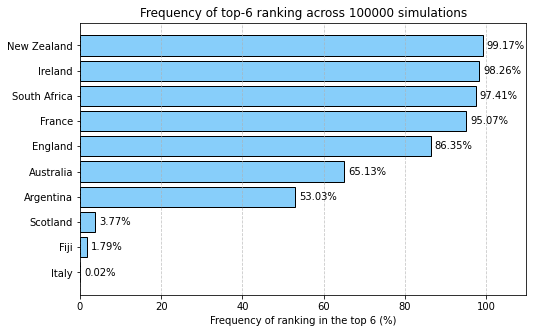

In [10]:
teams_sorted = [team for team, _ in results]
percentages_sorted = [pct for _, pct in results]

plt.figure(figsize=(8, 5),facecolor='white')
bars = plt.barh(teams_sorted, percentages_sorted, color='#87CEFA', edgecolor='black')

# Add percentage labels to the right of each bar
for bar, pct in zip(bars, percentages_sorted):
    plt.text(
        bar.get_width() + 1,   # a bit to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f"{pct}%",
        va='center',
        fontsize=10
    )

plt.xlabel('Frequency of ranking in the top 6 (%)')
plt.title(f"Frequency of top-6 ranking across {n_sim} simulations")
plt.xlim(0, 109.9)  # allow space for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # highest percentage at top

plt.savefig("top6_frequency.png")
plt.show()


### Highest ranked team

Finally, just for fun (as ultimately it does not really matter), we can look at who is ranked first.

In [11]:
# Count appearances as top team for each sim
top_counts = Counter()
for sim in sim_rank:
    top = [team for team, pts in sorted(sim.items(), key=lambda x: x[1], reverse=True)[:1]]
    for team in teams_to_analyse:
        if team in top:
            top_counts[team] += 1

total_sims = len(sim_rank)

# Build (team, percentage), filter > 0 (as we do not need to show teams never making the cut)
results = [
    (team, round(100 * top_counts[team] / total_sims, 2))
    for team in teams_to_analyse
    if top_counts[team] > 0
]

# Sort by percentage desc, then team name for tie-breaks
results.sort(key=lambda t: (-t[1], t[0]))

# Display
for team, pct in results:
    print(f"{team}: {pct}%")

New Zealand: 46.34%
South Africa: 24.7%
Ireland: 20.92%
France: 3.39%
England: 2.06%
Australia: 1.84%
Argentina: 0.74%


As before, we can generate a horizontal bar plot for the results.

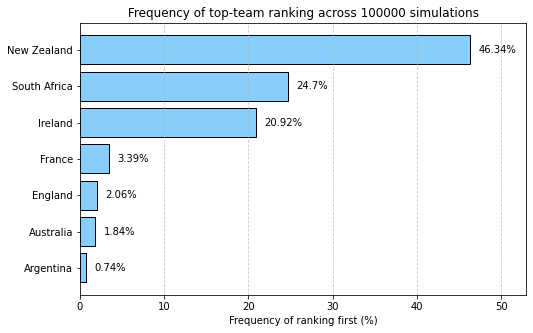

In [12]:
teams_sorted = [team for team, _ in results]
percentages_sorted = [pct for _, pct in results]

plt.figure(figsize=(8, 5),facecolor='white')
bars = plt.barh(teams_sorted, percentages_sorted, color='#87CEFA', edgecolor='black')

# Add percentage labels to the right of each bar
for bar, pct in zip(bars, percentages_sorted):
    plt.text(
        bar.get_width() + 1,   # a bit to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f"{pct}%",
        va='center',
        fontsize=10
    )

plt.xlabel('Frequency of ranking first (%)')
plt.title(f"Frequency of top-team ranking across {n_sim} simulations")
plt.xlim(0, 53)  # allow space for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # highest percentage at top

plt.savefig("top_team_frequency.png")
plt.show()


We're done!